# Rational Quadratic Spline

In [1]:
#@title Install Packages
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here", "setup.py"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os
    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [139]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config
import chex
config.update("jax_enable_x64", False)

import numpy as np
from functools import partial
from sklearn.preprocessing import StandardScaler

# library parameters
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_info_loss, plot_joint, plot_joint_prob

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
# get data
n_samples = 1_000
n_features = 1
data = get_classic(n_samples)[:, 1].reshape(-1, 1)



# Normalize Data
data = StandardScaler().fit_transform(data)

## Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

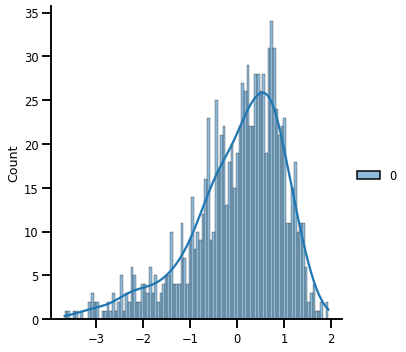

In [141]:
X = jnp.array(data, dtype=jnp.float32)

sns.displot(X, bins=100, kde=True)

## Spline Transformation

In [142]:
from distrax import RationalQuadraticSpline
from distrax._src.bijectors.rational_quadratic_spline import _rational_quadratic_spline_fwd, _rational_quadratic_spline_inv

### Initialization

In [143]:
from chex import Array, dataclass

@dataclass
class RQSplineParams:
    x_pos : Array
    y_pos : Array
    knot_slopes : Array

range_min = -5.0
range_max = 5.0
boundary_slopes = "identity"
n_bins = 10
n_features = 1
rsq_params = jnp.zeros((n_features, 3 * n_bins + 1))

# init model
rqs_clf = RationalQuadraticSpline(rsq_params, range_min, range_max, boundary_slopes)

# init params
params = RQSplineParams(x_pos=rqs_clf.x_pos, y_pos=rqs_clf.y_pos, knot_slopes=rqs_clf.knot_slopes)

In [144]:
def forward_and_log_det(params, x):
    fn = jnp.vectorize(
        _rational_quadratic_spline_fwd, signature="(),(n),(n),(n)->(),()"
    )
    y, logdet = fn(x, params.x_pos, params.y_pos, params.knot_slopes)
    return y, logdet



### Transform

In [145]:
X_trans, X_ldj = forward_and_log_det(params, X)

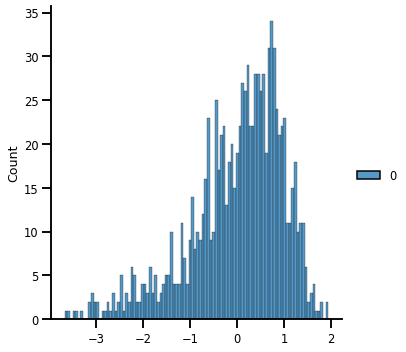

In [146]:
sns.displot(X_trans, bins=100)

### Inverse Transformation

In [147]:
def inverse_and_log_det(params, x):
    fn = jnp.vectorize(
        _rational_quadratic_spline_inv, signature="(),(n),(n),(n)->(),()"
    )
    y, logdet = fn(x, params.x_pos, params.y_pos, params.knot_slopes)
    return y, logdet

In [148]:
X_approx, X_ldj = inverse_and_log_det(params, X_trans)

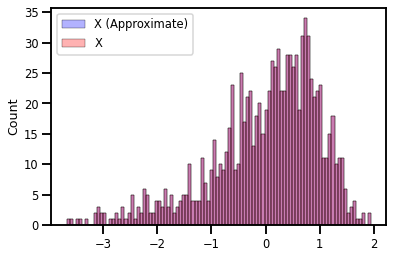

In [149]:
fig, ax = plt.subplots()
sns.histplot(X_approx.squeeze(), bins=100, label="X (Approximate)", fill=True, ax=ax, color='blue', alpha=0.3)
sns.histplot(X.squeeze(), bins=100, label="X", fill=True, ax=ax, color='Red', alpha=0.3)
ax.legend()
plt.show()

### Training

In [150]:
import jax.numpy as jnp
from jax import scipy

In [151]:

def log_prob(params, inputs):
    
    y, log_det = forward_and_log_det(params, inputs)
    # uniform nothing
    latent_prob = scipy.stats.norm.logpdf(y)
    
    # log probability
    log_prob = latent_prob.sum(axis=1) + log_det.sum(axis=1)
    
    
    return log_prob

In [153]:
x_lprob = log_prob(params, X)

In [154]:
x_lprob.min(), x_lprob.max()

(DeviceArray(-7.6515584, dtype=float32),
 DeviceArray(-0.91893923, dtype=float32))

In [155]:
def nll_loss(params, inputs):
    
    # negative log-likelihood
    return - log_prob(params, inputs).mean()

In [156]:
from jax.experimental import optimizers

lr = 0.01
epochs = 100
batch_size = 128


opt_init, opt_update, get_params = optimizers.adam(step_size=lr)
opt_state = opt_init(params)

In [157]:
X = np.array(data)

loss, grads_params = jax.value_and_grad(nll_loss)(params, X)

In [158]:
def step(i, opt_state, inputs):
    # get the parameters from the state
    params = get_params(opt_state)
    # calculate the loss AND the gradients
    loss, gradients = jax.value_and_grad(nll_loss)(params, inputs)
    
    # return loss AND new opt_state
    return loss, opt_update(i, gradients, opt_state)

# TO MAKE IT FAST
train_op = jax.jit(step)

In [159]:
import itertools
from jax import device_put
import tqdm
from jax import random


# initialize parameters
key = random.PRNGKey(123)
itercount = itertools.count()
permute_rng, rng = random.split(key)

train_data = jnp.array(X)

losses = list()

pbar = tqdm.trange(epochs)


with pbar:
    for i in pbar:

        # batch processing
        permute_rng, rng = random.split(rng)

        # randomly shuffle the data
        train_data = random.permutation(permute_rng, train_data)

        # Train
        avg_loss = []

        for batch_index in range(0, n_samples, batch_size):
            # compute loss
            loss, opt_state = train_op(
                next(itercount), 
                opt_state,
                train_data[batch_index:batch_index+batch_size],
            )
            
            
            # append batch
            avg_loss.append(float(loss))
        # average loss
        batch_loss = np.mean(np.stack(avg_loss))

        # Log losses
        losses.append(batch_loss)
        pbar.set_postfix({"loss": f"{batch_loss:.4f}"})

100%|██████████| 100/100 [00:03<00:00, 25.76it/s, loss=1.3169]


### Results

In [160]:
final_params = get_params(opt_state)
final_params

RQSplineParams(x_pos=DeviceArray([[-5.        , -4.056726  , -3.3869665 , -2.234538  ,
              -0.9518116 , -0.03275152,  1.1507118 ,  1.7791985 ,
               2.2010982 ,  4.        ,  5.        ]], dtype=float32), y_pos=DeviceArray([[-5.        , -4.363922  , -2.6579895 , -1.7668653 ,
              -1.0190147 , -0.23464103,  1.3617514 ,  2.6495605 ,
               4.342674  ,  4.        ,  5.        ]], dtype=float32), knot_slopes=DeviceArray([[1.        , 1.0453119 , 1.167544  , 0.77846205, 0.718953  ,
              0.84692734, 1.653961  , 1.0710163 , 0.06496515, 1.        ,
              1.        ]], dtype=float32))

In [161]:
final_params.x_pos

DeviceArray([[-5.        , -4.056726  , -3.3869665 , -2.234538  ,
              -0.9518116 , -0.03275152,  1.1507118 ,  1.7791985 ,
               2.2010982 ,  4.        ,  5.        ]], dtype=float32)

In [162]:
params.x_pos

DeviceArray([[-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.]], dtype=float32)

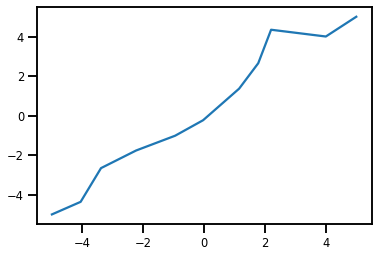

In [163]:
plt.plot(final_params.x_pos.squeeze(), final_params.y_pos.squeeze())

#### CDF

In [164]:

X_trans, X_ldj = forward_and_log_det(final_params, X[:, None])

<Figure size 432x288 with 0 Axes>

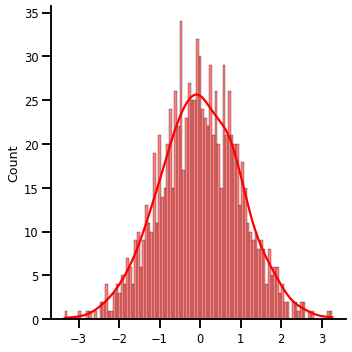

In [165]:
fig = plt.figure()
sns.displot(X_trans.squeeze(), bins=100, label="CDF", kde=True, fill=True, color='red')
plt.show()

#### Log PDF

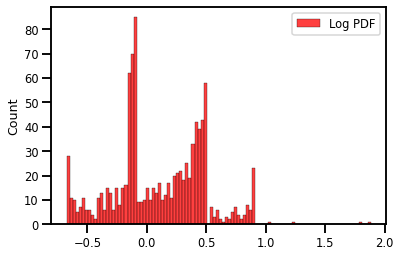

In [166]:
fig, ax = plt.subplots()
sns.histplot(X_ldj.squeeze(), bins=100, label="Log PDF", fill=True, ax=ax, color='red')
ax.legend()
plt.show()

In [167]:
X_approx, X_ldj = inverse_and_log_det(final_params, X_trans)

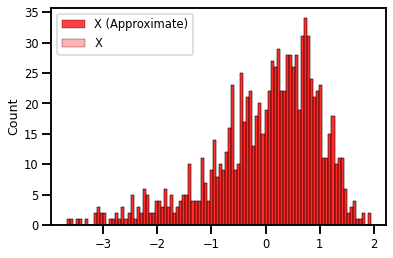

In [168]:
fig, ax = plt.subplots()
sns.histplot(X_approx.squeeze(), bins=100, label="X (Approximate)", fill=True, ax=ax, color='red')
sns.histplot(X.squeeze(), bins=100, label="X", fill=True, ax=ax, color='Red', alpha=0.3)

ax.legend()
plt.show()

In [169]:
# chex.assert_tree_all_close(X.squeeze(), X_approx.squeeze())

## 2D Example

In [170]:
# get data
n_samples = 1_000
n_features = 1
data = get_classic(n_samples)

<Figure size 432x288 with 0 Axes>

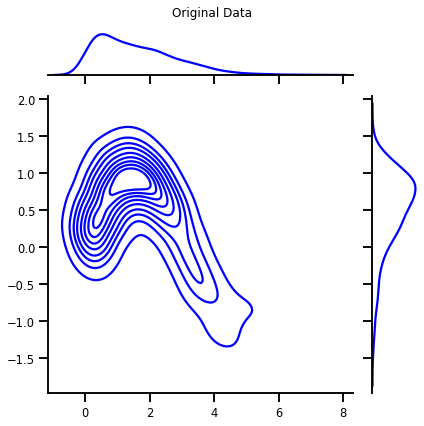

In [171]:
# plot data
plot_joint(data, "blue", "Original Data", kind='kde', logger=False)

### Model

In [172]:
from chex import Array, dataclass

@dataclass
class RQSplineParams:
    x_pos : Array
    y_pos : Array
    knot_slopes : Array

range_min = -10.0
range_max = 10.0
boundary_slopes = "identity"
n_bins = 20
n_features = 2
rsq_params = jnp.zeros((n_features, 3 * n_bins + 1))

# init model
rqs_clf = RationalQuadraticSpline(rsq_params, range_min, range_max, boundary_slopes)

# init params
params = RQSplineParams(x_pos=rqs_clf.x_pos, y_pos=rqs_clf.y_pos, knot_slopes=rqs_clf.knot_slopes)

### Training

In [173]:
opt_init, opt_update, get_params = optimizers.adam(step_size=lr)
opt_state = opt_init(params)

In [174]:
# initialize parameters
key = random.PRNGKey(123)
itercount = itertools.count()
permute_rng, rng = random.split(key)

train_data = jnp.array(data, jnp.float32)

losses = list()

pbar = tqdm.trange(epochs)


with pbar:
    for i in pbar:

        # batch processing
        permute_rng, rng = random.split(rng)

        # randomly shuffle the data
        train_data = random.permutation(permute_rng, train_data)

        # Train
        avg_loss = []

        for batch_index in range(0, n_samples, batch_size):
            # compute loss
            loss, opt_state = train_op(
                next(itercount), 
                opt_state,
                train_data[batch_index:batch_index+batch_size],
            )
            
            
            # append batch
            avg_loss.append(float(loss))
        # average loss
        batch_loss = np.mean(np.stack(avg_loss))

        # Log losses
        losses.append(batch_loss)
        pbar.set_postfix({"loss": f"{batch_loss:.4f}"})

100%|██████████| 100/100 [00:05<00:00, 19.82it/s, loss=2.1271]


### Results

In [95]:
final_params = get_params(opt_state)

In [ ]:
final_params

#### CDF

In [96]:
X_cdf, X_ldj = forward_and_log_det(final_params, train_data)

<Figure size 432x288 with 0 Axes>

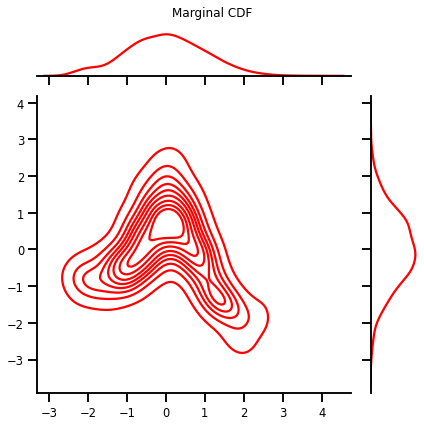

In [98]:
plot_joint(X_cdf, "Red", "Marginal CDF", kind='kde', logger=False)